<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/classify_Gaussian_blurs_autoencoder_remove_occlusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task:

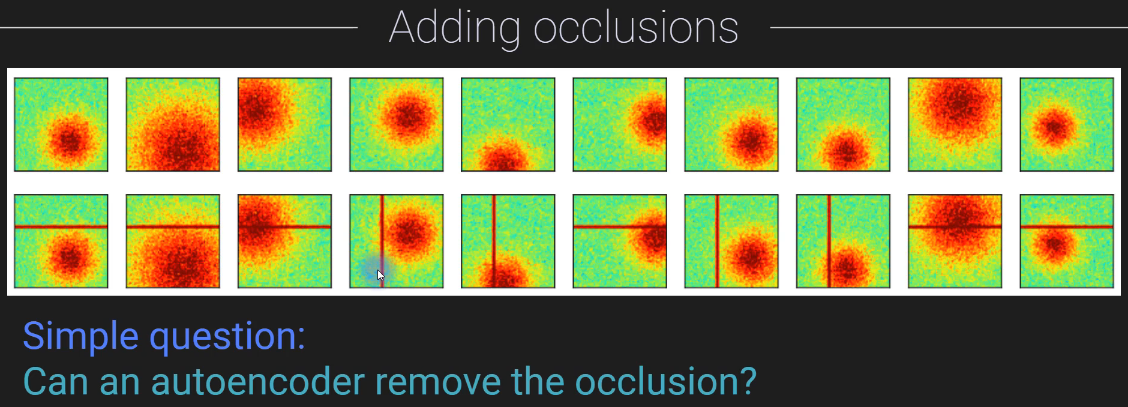

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [2]:
# create Gaussian blurs with varying widths and occluding bars:

nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize) # [-4., ..., 4.], 91 elements in total
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss) # [2., ..., 20.], 1000 elements in total

# initialize image tensors (w/ and wo/ occlusion)
imagesOcc   = torch.zeros(nGauss,1,imgSize,imgSize)
imagesNoOcc = torch.zeros(nGauss,1,imgSize,imgSize)

# loop over images:
for i in range(nGauss):

  # random centers, sampled from a normal distribution (mean=0, sd=1.5)
  ro = 1.5*np.random.randn(2) # ro: random offset

  # Gaussian with random centers and corresponding width
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # add noise: random numbers sampled from a standard normal distribution (mean=0, sd=1)
  G  = G + np.random.randn(imgSize,imgSize)/5
  # print("👀", G.shape) # (91, 91)

  # 1. fill the imagesNoOcc tensor: (91, 91) -> (1, 91, 91)
  imagesNoOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

  # generate occlusion:
  i1 = np.random.choice(np.arange(10,imgSize-10)) # start idx from [10,990)
  i2 = np.random.choice(np.arange(2,6)) # end idx from [2, 6)
  if np.random.randn()>0: # generate a single random value from a standard normal distribution (mean=0, sd=1)
    G[i1:i1+i2,] = 1 # horizontal bar
  else:
    G[:,i1:i1+i2] = 1 # vertical bar

  # 2. fill the imagesOcc tensor: (91, 91) -> (1, 91, 91)
  imagesOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

In [3]:
imagesOcc.shape

torch.Size([1000, 1, 91, 91])

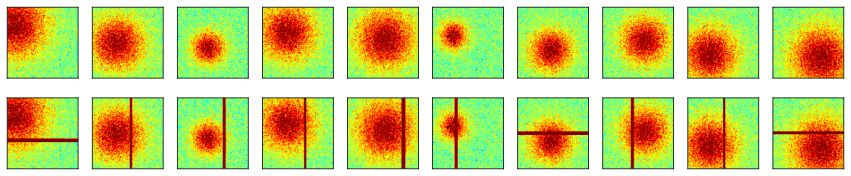

In [4]:
# visualize some images:

fig,ax = plt.subplots(2,10,figsize=(15,3))

for i in range(10):
  whichpic = np.random.randint(nGauss)
  ax[0,i].imshow(np.squeeze( imagesNoOcc[whichpic,:,:] ),vmin=-1,vmax=1,cmap='jet')
  ax[0,i].set_xticks([]), ax[0,i].set_yticks([])

  ax[1,i].imshow(np.squeeze( imagesOcc[whichpic,:,:] ),vmin=-1,vmax=1,cmap='jet')
  ax[1,i].set_xticks([]), ax[1,i].set_yticks([])

plt.show()

# # --------- method 2 -----------

# fig,axs = plt.subplots(3,7,figsize=(10,5))

# for i,ax in enumerate(axs.flatten()):
#   whichpic = np.random.randint(nGauss)
#   G = np.squeeze( images[whichpic,:,:] )
#   ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
#   ax.set_xticks([])
#   ax.set_yticks([])

# plt.show()

In [5]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1), # (inChans, outChans, k, s=1, p=0)
          nn.ReLU(),
          nn.MaxPool2d(2,2), # max pooling
          nn.Conv2d(6,4,3,padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
          )

      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(4,6,3,2),
          nn.ReLU(),
          nn.ConvTranspose2d(6,1,3,2),
          )

    def forward(self,x):
      return self.dec( self.enc(x) )

  # create the model instance
  net = gausnet()

  # loss function
  lossfun = nn.MSELoss() # to compare all of the output (numeric values) to the input

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

torch.Size([10, 1, 91, 91])


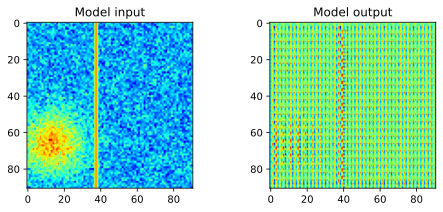

In [6]:
# test the model with one batch:

# build the model & create an model instance
net,lossfun,optimizer = makeTheNet()

# extract the first 10 imgs
yHat = net(imagesOcc[:10,:,:,:])
print(yHat.shape)

# plot an example image before and after passing through the model:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].imshow(torch.squeeze(imagesOcc[0,0,:,:]).detach(),cmap='jet') # the 1st original image
# torch.squeeze: remove any dimensions of size 1 from a PyTorch tensor
# .detach(): remove the tensor from the computational graph (as Matplotlib cannot work with the computational graph, it can only display the image data)
# cmap='jet': set the color map for the image to 'jet', which is a gradient from blue to red
ax[0].set_title('Model input')

ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet') # the 1st output image from the model
ax[1].set_title('Model output')

plt.show()

In [7]:
imagesOcc[0,0,:,:].shape

torch.Size([91, 91])

In [8]:
# a function to train the model:

def function2trainTheModel():

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  numepochs = 1000
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(nGauss,size=32,replace=False) # select 32 elements without replacement
    X = imagesOcc[pics2use,:,:,:]   # random input images w/ occlusion
    Y = imagesNoOcc[pics2use,:,:,:] # random target images wo/ occlusion

    # forward pass
    yHat = net(X)
    loss = lossfun(yHat,Y) # train the model to ignore the occluding bars
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

In [9]:
# train the model:
losses,net = function2trainTheModel()

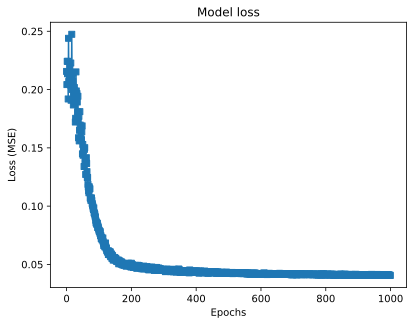

In [10]:
# show the results:

plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')

plt.show()

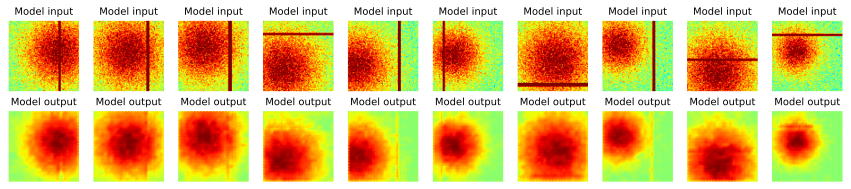

In [11]:
# visualize some images:

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = imagesOcc[pics2use,:,:,:]
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,3))

for i in range(10): # first 10 images

  G = torch.squeeze( X[i,0,:,:] ).detach()    # input image
  O = torch.squeeze( yHat[i,0,:,:] ).detach() # output image

  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input',fontsize=10)

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output',fontsize=10)

plt.show()

# Observations:

- Autoencoder cleans up a lot of the random noise. So the output of the model are cleaner and smoother.
- After training the model to ignore the occluding bars, the model did a pretty decent job at filtering out the occluding bars.